# NY Ecological Inference 

Code borrowed from ER_sneetches.ipynb

### Imports

In [1]:
import string
import time

import geopandas as gpd
from gerrychain import Graph
import maup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [3]:
def read_shape_file(filename: string) -> gpd.GeoDataFrame:
    start_time = time.time()
    df = gpd.read_file(filename)
    end_time = time.time()
    print(f"The time to import {filename} is: {(end_time - start_time) / 60} mins")
    return df

In [ ]:
def plot_ei(coef, const, shape: int, race):
    x = np.linspace(0, 1, 100).reshape((1,100))
    coef = np.array(coef).reshape((shape,1))
    const = np.array(const).reshape((shape,1))
    out = -coef * x + const
    for i in range(shape):
        plt.plot(np.linspace(0, 1, 100), out[i])
    plt.ylim(0, 1)
    plt.title(f"EI for {race} Voters")
    plt.show()

### Load congressional, election, population, and voting-age population data  

Expected time to load (MacBook Pro Intel chip):  
~... minutes

In [2]:
maup.progress.enabled = True

In [4]:
population_df = gpd.read_file("./ny_pl2020_b/ny_pl2020_p2_b.shp")
vap_df = gpd.read_file("./ny_pl2020_b/ny_pl2020_p4_b.shp")

In [5]:
election_df = gpd.read_file("./ny_2020_gen_2020_blocks/ny_2020_gen_2020_blocks.shp")
cong_df = gpd.read_file("./ny_cong_adopted_2022/CON22_June_03_2022.shp")

In [6]:
pop_column_names = ['P0020001', 'P0020002', 'P0020005', 'P0020006', 'P0020007',
                    'P0020008', 'P0020009', 'P0020010', 'P0020011']

In [7]:
vap_column_names = ['P0040001', 'P0040002', 'P0040005', 'P0040006', 'P0040007',
                    'P0040008', 'P0040009', 'P0040010', 'P0040011']

### Handle MAUP Reassignment

In [10]:
blocks_to_precincts_assignment = maup.assign(population_df.geometry, election_df.geometry)
vap_blocks_to_precincts_assignment = maup.assign(vap_df.geometry, election_df.geometry)

100%|█████████████████████████████████| 288819/288819 [04:17<00:00, 1122.59it/s]


In [11]:
district_col_name = "DISTRICT"

In [12]:
health_check = maup.doctor(election_df)

100%|█████████████████████████████████| 288819/288819 [04:21<00:00, 1105.14it/s]
/Users/travisoleson/anaconda3/envs/ei/lib/python3.11/site-packages/maup/repair.py:331: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlaps = inters[inters.area > 0].make_valid()


In [13]:
for name in pop_column_names:
    election_df[name] = population_df[name].groupby(blocks_to_precincts_assignment).sum()
for name in vap_column_names:
    election_df[name] = vap_df[name].groupby(vap_blocks_to_precincts_assignment).sum()

In [14]:
print(population_df['P0020001'].sum())
print(election_df['P0020001'].sum())
print(vap_df['P0040001'].sum())
print(election_df['P0040001'].sum())

20201249
20201249
16088135
16088135


In [15]:
print(health_check)

True


In [16]:
if not health_check:
    election_df = maup.smart_repair(election_df)

In [17]:
population_df = population_df.to_crs(population_df.estimate_utm_crs())
election_df = election_df.to_crs(population_df.estimate_utm_crs())
vap_df = vap_df.to_crs(population_df.estimate_utm_crs())
cong_df = cong_df.to_crs(population_df.estimate_utm_crs())

In [18]:
blocks_to_precincts_assignment = maup.assign(population_df.geometry, election_df.geometry)
vap_blocks_to_precincts_assignment = maup.assign(vap_df.geometry, election_df.geometry)

100%|█████████████████████████████████| 288819/288819 [04:16<00:00, 1126.83it/s]


In [19]:
health_check = maup.doctor(election_df)
print(health_check)

100%|█████████████████████████████████| 288819/288819 [04:19<00:00, 1113.16it/s]


True


In [21]:
precincts_to_districts_assignment = maup.assign(election_df["geometry"], cong_df["geometry"])

100%|███████████████████████████████████████████| 28/28 [00:04<00:00,  6.45it/s]


### Update Columns of Interest

In [22]:
election_df["CD"] = precincts_to_districts_assignment

In [23]:
print(set(election_df["CD"]))
for precinct_index in range(len(election_df)):
    election_df.at[precinct_index, "CD"] = cong_df.at[election_df.at[precinct_index, "CD"], district_col_name]
print(set(cong_df[district_col_name]))
print(set(election_df["CD"]))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


In [25]:
# "P0020001" == "TOTPOP"
pop_vals = [election_df.loc[election_df["CD"] == n, "P0020001"].sum() for n in range(1, 27)]
print(pop_vals)

[776971, 776971, 776971, 776971, 776971, 776971, 776971, 776972, 776972, 776971, 776971, 776971, 776971, 776972, 776971, 776971, 776971, 776971, 776971, 776971, 776971, 776971, 776971, 776971, 776971, 776971]


In [37]:
election_df.columns

Index(['GEOID20', 'STATEFP', 'COUNTYFP', 'PRECINCTID', 'VAP_MOD', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PREIPIE', 'G20PREOWRI',
       'geometry', 'P0020001', 'P0020002', 'P0020005', 'P0020006', 'P0020007',
       'P0020008', 'P0020009', 'P0020010', 'P0020011', 'P0040001', 'P0040002',
       'P0040005', 'P0040006', 'P0040007', 'P0040008', 'P0040009', 'P0040010',
       'P0040011', 'CD'],
      dtype='object')

In [39]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                    'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP',
                    'G20PREDBID': 'G20PRED', 'G20PRERTRU': 'G20PRER'}

In [40]:
election_df.rename(columns=rename_dict, inplace = True)

In [41]:
election_df.drop(columns=['G20PRELJOR', 'G20PREGHAW', 'G20PREIPIE', 'G20PREOWRI',], inplace=True)
print(election_df.columns)

['GEOID20',
 'STATEFP',
 'COUNTYFP',
 'PRECINCTID',
 'VAP_MOD',
 'G20PRED',
 'G20PRER',
 'geometry',
 'TOTPOP',
 'HISP',
 'NH_WHITE',
 'NH_BLACK',
 'NH_AMIN',
 'NH_ASIAN',
 'NH_NHPI',
 'NH_OTHER',
 'NH_2MORE',
 'VAP',
 'HVAP',
 'WVAP',
 'BVAP',
 'AMINVAP',
 'ASIANVAP',
 'NHPIVAP',
 'OTHERVAP',
 '2MOREVAP',
 'CD']

### Create EI Dataframe

In [61]:
ei_df = election_df.copy()

In [62]:
ei_df.drop(columns=['GEOID20', 'STATEFP', 'COUNTYFP', 'PRECINCTID', 'VAP_MOD', 'geometry',
                    'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
                    'AMINVAP', 'ASIANVAP','NHPIVAP', 'OTHERVAP', '2MOREVAP',], inplace=True)

,G20PRED,G20PRER,TOTPOP,HISP,VAP,HVAP,WVAP,BVAP,CD
0,0.0,0.0,0,0,0,0,0,0,20
1,0.0,0.0,0,0,0,0,0,0,20
2,0.0,0.0,0,0,0,0,0,0,20
3,0.0,0.0,0,0,0,0,0,0,20
4,0.0,0.0,0,0,0,0,0,0,20


In [63]:
ei_df = ei_df.groupby("CD").sum()
ei_df.head()

In [64]:
ei_df.head()

,G20PRED,G20PRER,TOTPOP,HISP,VAP,HVAP,WVAP,BVAP
CD,,,,,,,,
1,212149.42,211234.86,776971,120450,624895,83977,464464,27050
2,175558.80,180970.62,776971,215177,611926,152022,363964,58128
3,213372.44,180842.67,776971,108842,621744,79497,362345,21917
4,223909.75,166537.30,776971,171562,609622,123665,322474,100740
5,216606.45,49624.45,776971,159791,616662,120717,81185,251465


#### Partition Data

In [67]:
X_HISP = ei_df[["HVAP"]]
X_BLACK = ei_df[["BVAP"]]
X_WHITE = ei_df[["WVAP"]]

In [68]:
Y_HISP = ei_df[["G20PRED"]]
Y_BLACK = ei_df[["G20PRED"]]
Y_WHITE = ei_df[["G20PRED"]]

### Run Ecological Inference & Ecological Regression

#### Fit Liner Models

In [69]:
model_1 = LinearRegression()
model_1.fit(X_HISP, Y_HISP)

LinearRegression()

In [70]:
model_2 = LinearRegression()
model_2.fit(X_BLACK, Y_BLACK)

LinearRegression()

In [71]:
model_3 = LinearRegression()
model_3.fit(X_WHITE, Y_WHITE)

LinearRegression()

In [82]:
const1 = Y_HISP["G20PRED"]/(1-X_HISP["HVAP"])
coef1 = X_HISP["HVAP"]/(1-X_HISP["HVAP"])

# print("HISP")
# print(const1)
# print(coef1)

In [83]:
const2 = Y_BLACK["G20PRED"]/(1-X_BLACK["BVAP"])
coef2 = X_BLACK["BVAP"]/(1-X_BLACK["BVAP"])

# print("BLACK")
# print(const1)
# print(coef1)

In [84]:
const3 = Y_WHITE["G20PRED"]/(1-X_WHITE["WVAP"])
coef3 = X_WHITE["WVAP"]/(1-X_WHITE["WVAP"])

# print("WHITE")
# print(const1)
# print(coef1)

#### Display EI Results

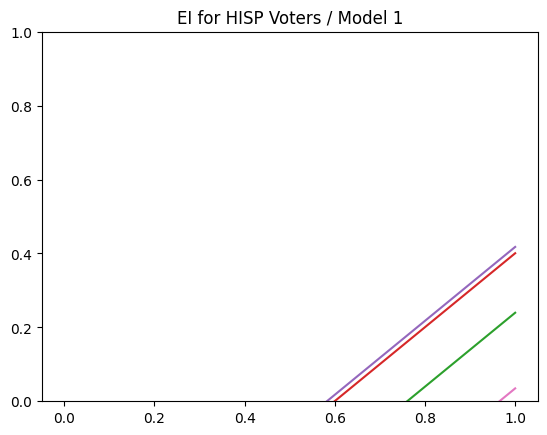

In [85]:
# x1 = np.linspace(0, 1, 100).reshape((1,100))
# coef1 = np.array(coef1).reshape((26,1))
# const1 = np.array(const1).reshape((26,1))
# out1 = -coef1 * x1 + const1
# for i in range(26):
#     plt.plot(np.linspace(0, 1, 100), out1[i])
# plt.ylim(0, 1)
# plt.title("EI for HISP Voters / Model 1")
# plt.show()

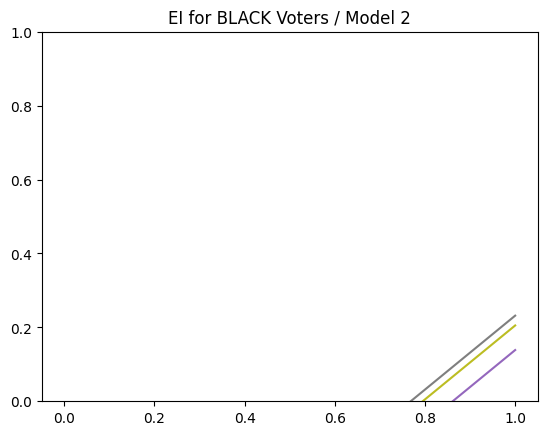

In [86]:
# x2 = np.linspace(0, 1, 100).reshape((1,100))
# coef2 = np.array(coef2).reshape((26,1))
# const2 = np.array(const2).reshape((26,1))
# out2 = -coef2 * x2 + const2
# for i in range(26):
#     plt.plot(np.linspace(0, 1, 100), out2[i])
# plt.ylim(0, 1)
# plt.title("EI for BLACK Voters / Model 2")
# plt.show()

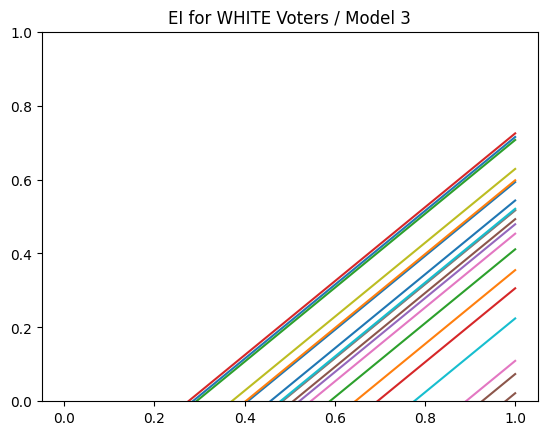

In [87]:
# x3 = np.linspace(0, 1, 100).reshape((1,100))
# coef3 = np.array(coef3).reshape((26,1))
# const3 = np.array(const3).reshape((26,1))
# out3 = -coef3 * x3 + const3
# for i in range(26):
#     plt.plot(np.linspace(0, 1, 100), out3[i])
# plt.ylim(0, 1)
# plt.title("EI for WHITE Voters / Model 3")
# plt.show()

In [2]:
plot_ei(coef1, const1, 26, "Hispanic")

In [3]:
plot_ei(coef2, const2, 26, "Black")

In [4]:
plot_ei(coef3, const3, 26, "White")